## Introduction

This notebook is an implementation of the greedy poisoning attack on regression models as described in Kornaropoulos et. al - *The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures* (paper available on [Arxiv](https://arxiv.org/abs/2008.00297))

In [62]:
import csv
import numpy as np
import pandas as pd
import operator

from sklearn.linear_model import LinearRegression
from sklearn import metrics 
import concurrent.futures

In [3]:
import matplotlib.pyplot as plt  
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def plot_distribution_of_poisoning_keys(poisoning_keys, x):
    # we observe that poisoning keys are densly populated together
    # get range for x-axis by looking at first and last element
    plt.hist(poisoning_keys, bins = 100, range=[x[0][0], x[len(x)-1][0]])
    plt.show()

In [4]:
def plot_poisoned_and_non_poisoned_regression_line(x, y, x_poisoned, y_poisoned):
    regressor = LinearRegression()
    regressor.fit(x, y) 
    y_pred = regressor.predict(x)
    
    regressor_poisoned = LinearRegression()
    regressor_poisoned.fit(x_poisoned, y_poisoned) 
    
    #y_pred_poisoned = regressor_poisoned.predict(x_poisoned)
    #plt.scatter(x, y,  color='black')
    plt.scatter(x_poisoned, y_poisoned,  color='black')
    
    abline(regressor_poisoned.coef_, regressor_poisoned.intercept_, color="red", label="Poisoned regression line")
    abline(regressor.coef_, regressor.intercept_, color="blue", label="Non-poisoned regression line")
    label= "Poisoned vs. non-poisoned regression line for n="+ str(x.shape[0]) + " keys"
    plt.title(label=label)
    plt.show()

In [5]:
def abline(slope, intercept, color, label):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color, label = label)
    plt.legend()
    plt.xlabel('Keys')
    plt.ylabel('Rank')

In [26]:
def calculate_mean_squared_error(x, y):
    regressor = LinearRegression()
    regressor.fit(x, y) 
    y_pred = regressor.predict(x)
    print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  
    # Plot outputs
    plt.scatter(x, y,  color='black')
    abline(regressor.coef_, regressor.intercept_, color="blue", label="Non-poisoned regression line")
    label= "Regression line prior to poisoning attack for n=2000 keys"
    plt.title(label=label)
    plt.show()

## Algorithm 1 - Greedy Poisoning Regression CDF

The following code implements **Algorithm 1 (Greedy Poisoning Regression CDF)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [7]:
"""
Source: Scipy - https://github.com/scipy/scipy/blob/v1.7.0/scipy/stats/stats.py#L8631-L8737
"""
def rankdata(array):
    #arr = np.ravel(np.asarray(array))
    algo = 'mergesort'
    sorter = np.argsort(array, kind=algo)

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)
    return inv + 1

In [28]:
# Extract non-occupied keys for a given sequence of legitimate and poisoning keys
def partition_non_occupied_keys(K, P):
    keyset = np.append(K, list(P))
    keyset = np.sort(keyset)
    
    n = keyset.shape[0]
    
    lower_bound = int(keyset[0]-1)
    upper_bound = int(keyset[n-1]+1)
    
    # convert to set to speed up lookup
    keyset = set(keyset)
    
    endpoints = set()
    is_in_sequence = False
    for i in range(lower_bound, upper_bound + 1):
        # TODO: We limit the number of endpoints to improve performance
        if len(endpoints) > 100:
            return  np.array(list(endpoints), dtype=np.uint64)
        elif (i not in keyset and is_in_sequence is False): # if key i is at start of sequence
            #print("Adding " + str(i) + " to non_occupied_keys")
            is_in_sequence = True
            endpoints.add(i)
        elif i not in keyset and is_in_sequence is True and (i+1) in keyset: # if key i is at end of sequence
            #print("Adding " + str(i) + " to non_occupied_keys because " + str(i+1) + " is not in keyset")
            endpoints.add(i)
        else: 
            is_in_sequence = False
        
    return np.array(list(endpoints), dtype=np.uint64)
        
# Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence
def compute_rank_for_endpoints(endpoints, keyset):
    computed_rank_for_endpoint = []
    
    for endpoint in endpoints:
        keyset_extended = np.append(keyset, endpoint)
        
        rank = rankdata(keyset_extended)
        
        # extract rank for the last element in the list (the endpoint)
        rank_of_endpoint = rank[len(rank) - 1]
        computed_rank_for_endpoint.append(int(rank_of_endpoint))
    
    return computed_rank_for_endpoint

In [41]:
def obtain_poisoning_keys(p, keyset, rankset):
    # Total number of elements
    n = keyset.shape[0]

    # Number of posoning keys P
    P = int(p * n)
    poisoning_keys = set()
    

    while len(poisoning_keys) < P:
        #print("Current status: " + str(len(poisoning_keys)) + " out of " + str(P) + " poisoning keys generated")
        # Partition the non-occupied keys into subsequences such that each subsequence consists of consecutive non-occupied keys;
        # Extract the endpoints of each subsequence and sort them to construct the new sequence of endpoints S(i), where i <= 2(n + j);
        
        # S: endpoints
        S = partition_non_occupied_keys(keyset, poisoning_keys)
        #print("Length of endpoints: ", len(S))
        
        # TODO: Investigate impact - we downsample the list of endpoints to max n = 1000
        # Limit number of endpoints to n = 50
        S = np.random.choice(S, size = 50)
        # Sort S to make it continuously increasing
        S = np.sort(S)

        # Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence T (i), where i <= 2(n + j) ;
        # T: list_rank
        T = compute_rank_for_endpoints(S, keyset)

        # Compute the effect of choosing S(1) as a poisoning key and inserting it to K ∪ P with the appropriate rank adjustments. 
        # Specifically, evaluate the sequences each of which is the mean M for a different variable, e.g., K, R, KR. Compute MK (1), MK2 (1), MKR(1), and L(1) ;

        
        delta_S = {}
        M_K = {}
        M_K_square = {}
        M_R = {}
        M_R_square = {}
        M_KR = {}
        L = {}
        
        # Calculate M_K(1), M_R(1) etc.
        # insert first potential poisoning key
        current_keyset = np.append(keyset, S[0])
        M_K[0] = np.mean(current_keyset)

        current_rankset = np.append(rankset, T[0])
        M_R[0] = np.mean(current_rankset)

        M_K_square[0] = np.mean(current_keyset**2)

        M_R_square[0] = np.mean(current_rankset**2)

        M_KR[0] = np.mean(current_keyset*current_rankset)

        nominator = (M_KR[0] - (M_K[0] * M_R[0]))**2
        denominator = M_K_square[0] - (M_K[0])**2
        L[0] = - (nominator / denominator) + M_R_square[0] - (M_R[0])**2

        for i in range(1, len(S)-1):
            # Calculate M_K(i), M_R(i) etc.
            delta_S[i] = S[i+1] - S[i] 

            M_K[i] = M_K[i-1] + delta_S[i] / (n) 
            #print("M_K_square: ", M_K_square[i-1])
            #print("S[i]: ", S[i])
            #print("delta_S[i]: ", delta_S[i])
            M_K_square[i] = M_K_square[i-1] + ( (( 2 * S[i] + delta_S[i]) * delta_S[i]) / (n + 1) )
            
            M_R[i] = (n + 2) / 2
            M_R_square[i] = ((n+2)*(2*n+3)) / 6
            M_KR[i] = M_KR[i-1] + ( T[i-1] * delta_S[i]) / (n + 1)

            nominator = (M_KR[i] - M_K[i]*M_R[i])**2
            denominator = M_K_square[i] - (M_K[i])**2
            L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2

        # get argmax of items in L
        optimal_key_index = max(L.items(), key=operator.itemgetter(1))[0]
        #print("Generated poisoning key: ", S[optimal_key_index])
        poisoning_keys.add(S[optimal_key_index])
    
    return poisoning_keys

## Linear regression with non-poisoned keys

In [60]:
df = pd.read_csv('../data/random_2000.csv', sep=',',header=None)

x = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])

Mean Squared Error: 22.990043047393875


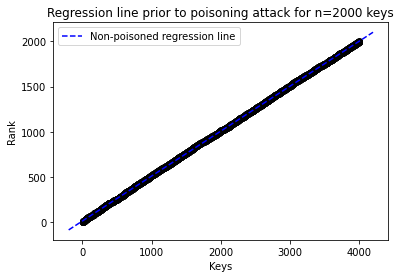

In [31]:
calculate_mean_squared_error(x, y)

## Linear regression with poisoned keys

In [32]:
poisoning_keys = obtain_poisoning_keys(p = 0.2, keyset=x, rankset=y)

Current status: 0 out of 400 poisoning keys generated
Generated poisoning key:  244
Current status: 1 out of 400 poisoning keys generated
Generated poisoning key:  231
Current status: 2 out of 400 poisoning keys generated
Generated poisoning key:  247
Current status: 3 out of 400 poisoning keys generated
Generated poisoning key:  235
Current status: 4 out of 400 poisoning keys generated
Generated poisoning key:  253
Current status: 5 out of 400 poisoning keys generated
Generated poisoning key:  257
Current status: 6 out of 400 poisoning keys generated
Generated poisoning key:  241
Current status: 7 out of 400 poisoning keys generated
Generated poisoning key:  245
Current status: 8 out of 400 poisoning keys generated
Generated poisoning key:  234
Current status: 9 out of 400 poisoning keys generated
Generated poisoning key:  263
Current status: 10 out of 400 poisoning keys generated
Generated poisoning key:  270
Current status: 11 out of 400 poisoning keys generated
Generated poisoning 

Generated poisoning key:  459
Current status: 112 out of 400 poisoning keys generated
Generated poisoning key:  473
Current status: 113 out of 400 poisoning keys generated
Generated poisoning key:  452
Current status: 114 out of 400 poisoning keys generated
Generated poisoning key:  477
Current status: 115 out of 400 poisoning keys generated
Generated poisoning key:  475
Current status: 116 out of 400 poisoning keys generated
Generated poisoning key:  476
Current status: 117 out of 400 poisoning keys generated
Generated poisoning key:  478
Current status: 118 out of 400 poisoning keys generated
Generated poisoning key:  470
Current status: 119 out of 400 poisoning keys generated
Generated poisoning key:  482
Current status: 120 out of 400 poisoning keys generated
Generated poisoning key:  451
Current status: 121 out of 400 poisoning keys generated
Generated poisoning key:  484
Current status: 122 out of 400 poisoning keys generated
Generated poisoning key:  486
Current status: 123 out 

Generated poisoning key:  705
Current status: 233 out of 400 poisoning keys generated
Generated poisoning key:  709
Current status: 234 out of 400 poisoning keys generated
Generated poisoning key:  715
Current status: 235 out of 400 poisoning keys generated
Generated poisoning key:  706
Current status: 236 out of 400 poisoning keys generated
Generated poisoning key:  721
Current status: 237 out of 400 poisoning keys generated
Generated poisoning key:  718
Current status: 238 out of 400 poisoning keys generated
Generated poisoning key:  723
Current status: 239 out of 400 poisoning keys generated
Generated poisoning key:  696
Current status: 240 out of 400 poisoning keys generated
Generated poisoning key:  701
Current status: 241 out of 400 poisoning keys generated
Generated poisoning key:  733
Current status: 242 out of 400 poisoning keys generated
Generated poisoning key:  741
Current status: 243 out of 400 poisoning keys generated
Generated poisoning key:  724
Current status: 244 out 

Generated poisoning key:  925
Current status: 341 out of 400 poisoning keys generated
Generated poisoning key:  935
Current status: 342 out of 400 poisoning keys generated
Generated poisoning key:  938
Current status: 343 out of 400 poisoning keys generated
Generated poisoning key:  933
Current status: 344 out of 400 poisoning keys generated
Generated poisoning key:  932
Current status: 345 out of 400 poisoning keys generated
Generated poisoning key:  876
Current status: 346 out of 400 poisoning keys generated
Generated poisoning key:  947
Current status: 347 out of 400 poisoning keys generated
Generated poisoning key:  949
Current status: 348 out of 400 poisoning keys generated
Generated poisoning key:  946
Current status: 349 out of 400 poisoning keys generated
Generated poisoning key:  954
Current status: 350 out of 400 poisoning keys generated
Generated poisoning key:  936
Current status: 351 out of 400 poisoning keys generated
Generated poisoning key:  953
Current status: 352 out 

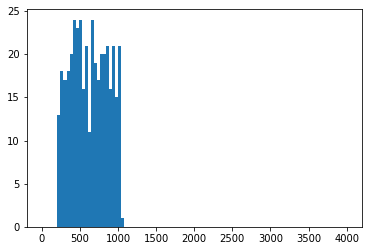

In [33]:
plot_distribution_of_poisoning_keys(poisoning_keys, x)

In [34]:
x_poisoned = np.append(x, list(poisoning_keys))
y_poisoned = rankdata(x_poisoned)
x_poisoned = x_poisoned.reshape(-1,1)

Mean Squared Error: 8675.828648355759


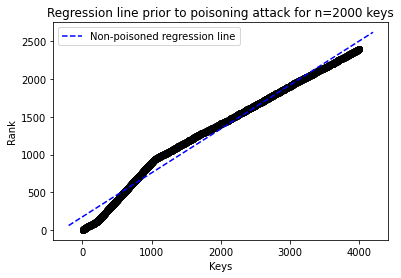

In [35]:
calculate_mean_squared_error(x_poisoned, y_poisoned)

In [36]:
#ratio_loss =  mse_poisoned / mse_legitimates

### Visualization

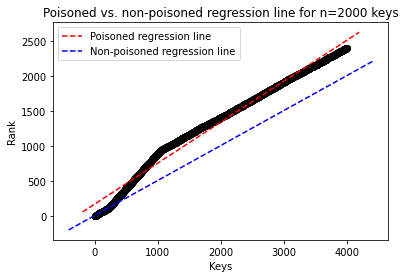

In [37]:
# Plot outputs
plot_poisoned_and_non_poisoned_regression_line(x, y, x_poisoned, y_poisoned)

### Write poisoned keyset to file

In [94]:
#poisoned_keyset = pd.DataFrame(data=list(X_poisoned))
#poisoned_keyset.to_csv("../data/poisoned_keyset_2000.csv", sep=',',index=False)

# Multicore poisoning attack

In [69]:
len(x)

2000

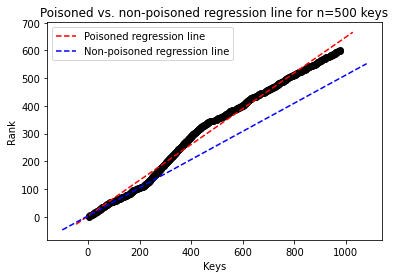

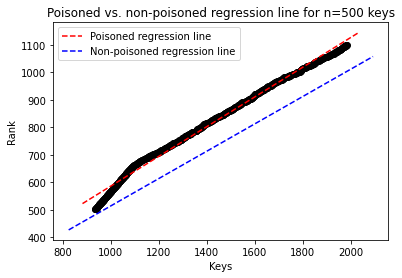

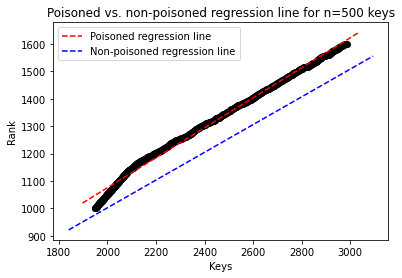

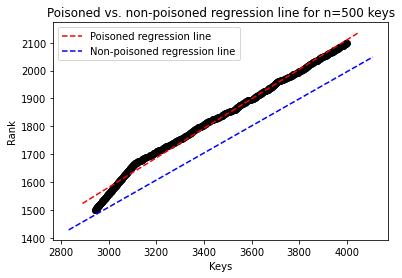

In [77]:
num_processes = 4

# split x, y into equal parts
x_split = np.split(x, num_processes)
y_split = np.split(y, num_processes)
poisoning_keys = {}

for i in range(num_processes):
    poisoning_keys[i] = obtain_poisoning_keys(p = 0.2, keyset = x_split[i], rankset = y_split[i])
    x_poisoned = np.append(x_split[i], list(poisoning_keys[i]))
    
    y_poisoned = rankdata(x_poisoned)
    y_poisoned = y_poisoned + i * len(x)/num_processes
    
    x_poisoned = x_poisoned.reshape(-1,1)
    plot_poisoned_and_non_poisoned_regression_line(x_split[i], y_split[i], x_poisoned, y_poisoned)

## Linear regression experiments with different key sizes / different poisoning percentages

In [38]:
import random

def generate_uniform_data(size):
    
    data = random.sample(range(2, size * 2), size)
    data.sort()
    return data

-------------------------
Dataset size:  500
Mean Squared Error: 18.2363266506005
Mean Squared Error: 25.36408015714413
Mean Squared Error: 40.97963074661566
Mean Squared Error: 53.93221416097517
Mean Squared Error: 73.9361161101124
Mean Squared Error: 94.57668989499048
Mean Squared Error: 118.97960698832175
Mean Squared Error: 144.93693842523246
Mean Squared Error: 172.49174494497686
Mean Squared Error: 202.44003411121824
Mean Squared Error: 233.7533726496023
Mean Squared Error: 264.52644573432576
Mean Squared Error: 297.82309531688657
Mean Squared Error: 336.5747501165933
Mean Squared Error: 375.96595193313675


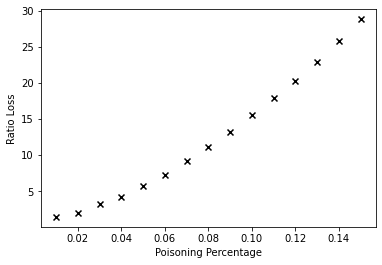

-------------------------
Dataset size:  1000
Mean Squared Error: 34.30026070607344
Mean Squared Error: 60.73765473490115
Mean Squared Error: 108.54714791011645
Mean Squared Error: 158.35313688282835
Mean Squared Error: 226.33553384950494
Mean Squared Error: 306.01694917655266
Mean Squared Error: 402.95436483240604
Mean Squared Error: 505.6325100330358
Mean Squared Error: 625.0387814712624
Mean Squared Error: 743.9581430306605
Mean Squared Error: 875.0859988776623
Mean Squared Error: 1017.4113517360164
Mean Squared Error: 1154.3120572844853
Mean Squared Error: 1286.5713840199523
Mean Squared Error: 1455.494221114446


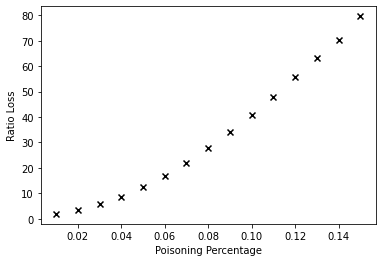

In [42]:
dataset_sizes = [500, 1000]

for dataset_size in dataset_sizes:
    
    print("-------------------------")
    print("Dataset size: ", dataset_size)
    X = generate_uniform_data(dataset_size)
    X = np.array(X).reshape(-1, 1)
    
    y = np.linspace(1, dataset_size, num=dataset_size)

    poisoning_percentages = np.linspace(0.01, 0.15, num= 15)

    ratio_losses = []
    
    regressor_legitimate = LinearRegression()
    regressor_legitimate.fit(X, y) 

    y_pred = regressor_legitimate.predict(X)
    mse_legitimate = metrics.mean_squared_error(y, y_pred)

    for percentage in poisoning_percentages:
        poisoning_keys = obtain_poisoning_keys(p = percentage, keyset = X, rankset = y)

        #plot_poisoning_keys(poisoning_keys)

        X_poisoned = np.append(X, list(poisoning_keys))
        y_poisoned = rankdata(X_poisoned)

        X_poisoned = X_poisoned.reshape(-1,1)
        regressor_poisoned = LinearRegression()
        regressor_poisoned.fit(X_poisoned, y_poisoned)  

        y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

        print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
        mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)
        ratio_loss =  mse_poisoned / mse_legitimate

        ratio_losses.append(ratio_loss)

    plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
    plt.xlabel('Poisoning Percentage')
    plt.ylabel('Ratio Loss')
    plt.show()